# Baseline Univariate Model: Autoregressive Model (AR)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AutoRegResults
from statsmodels.tsa.ar_model import ar_select_order
import yfinance as yf
from statsmodels.stats.stattools import jarque_bera
import copy
import matplotlib.patches as mpatches
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from scipy.stats import binom
import ast
import matplotlib as mpl
import matplotlib.pyplot as plt

Read stock data

In [26]:
df_prices = pd.read_csv("../data/stock_data_daily_pct_change.csv")
df_prices.index = pd.DatetimeIndex(df_prices["Date"]).to_period("D")
df_prices = df_prices.drop('Date', axis = 1)
df_prices = df_prices.drop("Date.1", axis = 1)

# Drop columns with little amount of data (determined in "Sentiment Analysis.ipynb")
df_prices = df_prices.drop(["LLY", "NVDA", "MA", "UNH", "V"], axis = 1)
df_prices

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE
Date,,,,,,,,,,,,,,,
2011-01-04,0.005219,0.003931,0.003524,0.004288,0.001878,0.004695,0.014473,-0.020699,0.003849,-0.003698,0.008437,-0.018125,0.002779,0.008602,0.017534
2011-01-05,0.008180,-0.003204,0.018258,0.013026,0.005999,-0.002670,0.012229,-0.005950,-0.006573,-0.001747,-0.000631,-0.003172,-0.002310,0.005777,0.006671
2011-01-06,-0.000808,0.029286,-0.004138,-0.008324,0.039135,0.006426,-0.004922,-0.007245,-0.008270,-0.008202,-0.001580,-0.004051,-0.001698,0.013676,0.003865
2011-01-07,0.007161,-0.007634,-0.013158,-0.001991,0.012912,0.005453,-0.018885,-0.001745,0.002224,0.005514,-0.009650,-0.001162,-0.002937,0.007825,0.008801
2011-01-10,0.018833,-0.013287,0.010526,-0.004367,0.007436,-0.006086,-0.005500,0.002225,-0.006472,-0.008554,-0.007029,0.000291,-0.002171,-0.004016,-0.004362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.016319,0.000000,0.006007,0.003638,0.033605,0.005004,-0.000292,-0.001092,-0.010475,0.005431,0.002602,-0.008952,-0.003670,0.001747,0.002294
2019-12-24,0.000951,-0.000191,0.001422,-0.002114,0.014384,-0.003842,0.002770,-0.003642,0.004033,0.000083,-0.003483,0.006660,0.002562,-0.003270,-0.000763
2019-12-26,0.019840,0.008197,0.008518,0.044467,0.013380,0.001571,0.010612,0.005666,0.000084,0.002160,-0.000685,0.000680,0.000000,-0.001093,0.002291


In [27]:
# importing sentiment data, not so that it can be used, but purely to filter out the stocks price dates that are not in the sentiment data as they are removed in the VAR model fitting aswell during merging.

df_sentiment = pd.read_csv("../data/sentiment_daily_data.csv")
df_sentiment.index = pd.DatetimeIndex(df_sentiment["release_date"]).to_period("D")
df_sentiment = df_sentiment.drop('release_date', axis = 1)
df_sentiment

,AAPL_daily,AAPL_diff,AMZN_daily,AMZN_diff,BAC_daily,BAC_diff,CVX_daily,CVX_diff,HD_daily,HD_diff,...,PFE_daily,PFE_diff,PG_daily,PG_diff,TSLA_daily,TSLA_diff,WMT_daily,WMT_diff,XOM_daily,XOM_diff
release_date,,,,,,,,,,,,,,,,,,,,,
2014-01-04,0.9747,-0.9876,0.9870,0.0,1.8862,0.0000,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9595,0.0000
2014-01-05,2.6382,1.6635,0.9870,0.0,0.9956,-0.8906,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9977,0.0382
2014-01-06,2.6382,0.0000,0.9870,0.0,0.9956,0.0000,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,-0.0010
2014-01-07,-0.2695,-2.9077,0.9870,0.0,2.9495,1.9539,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,0.0000
2014-01-08,-0.2695,0.0000,0.9870,0.0,0.9862,-1.9633,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-09,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,1.9594,0.7939,0.9975,0.0,...,1.9891,0.0000,-0.9581,0.0,20.7979,0.0,0.3612,-0.6384,-0.9922,0.0000
2020-02-10,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,1.9594,0.0000,0.9975,0.0,...,1.9891,0.0000,-0.9581,0.0,20.7979,0.0,0.3612,0.0000,-0.5306,0.4616
2020-02-11,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,0.0732,-1.8862,0.9975,0.0,...,1.5383,-0.4508,-0.9581,0.0,20.7979,0.0,0.3612,0.0000,1.9926,2.5232


In [28]:
# merging and throwing away all the sentiment columns, as they are not needed for the AR model
df_prices = pd.merge(df_prices, df_sentiment, left_index= True, right_index = True)[['AAPL', 'MSFT', 'BAC', 'AMZN', 'TSLA', 'XOM', 'JPM', 'KO', 'WMT', 'CVX',
       'JNJ', 'HD', 'PG', 'MRK', 'PFE']]
df_prices

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE
2014-01-06,0.005453,-0.021133,0.015235,-0.007088,-0.017117,0.001507,0.005796,-0.004696,-0.005595,-0.002654,0.005226,-0.009647,0.002362,0.000201,0.000983
2014-01-07,-0.007151,0.007750,-0.009604,0.011178,0.016054,0.014149,-0.011525,0.002980,0.003069,0.008466,0.021228,0.004932,0.009673,0.007439,0.006220
2014-01-08,0.006333,-0.017852,0.004848,0.009773,0.012855,-0.003265,0.009431,-0.011142,-0.007903,-0.014232,-0.001379,0.005276,-0.014493,-0.006386,0.006831
2014-01-09,-0.012770,-0.006432,0.015079,-0.002264,-0.024788,-0.009728,-0.001869,-0.005258,0.003341,0.000000,0.006053,-0.004394,0.002244,-0.005423,-0.000646
2014-01-10,-0.006672,0.014354,-0.003565,-0.008354,-0.012269,0.007618,-0.004595,0.010068,-0.000640,-0.018493,0.000106,0.005394,-0.001492,0.007270,-0.007759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.016319,0.000000,0.006007,0.003638,0.033605,0.005004,-0.000292,-0.001092,-0.010475,0.005431,0.002602,-0.008952,-0.003670,0.001747,0.002294
2019-12-24,0.000951,-0.000191,0.001422,-0.002114,0.014384,-0.003842,0.002770,-0.003642,0.004033,0.000083,-0.003483,0.006660,0.002562,-0.003270,-0.000763
2019-12-26,0.019840,0.008197,0.008518,0.044467,0.013380,0.001571,0.010612,0.005666,0.000084,0.002160,-0.000685,0.000680,0.000000,-0.001093,0.002291
2019-12-27,-0.000379,0.001828,-0.004786,0.000551,-0.001300,-0.003422,0.000719,0.005998,0.000586,-0.002487,-0.000548,-0.003849,0.006948,0.001752,-0.001524


### Rationale behind fitting an AR model 

The idea of this AR model is to serve as a baseline to compare the prediction of the VAR model. If the prediction accuracy (i.e. $RMSE$) does not improve when introducing the articles' sentiment data, then $H_2$ (i.e. using sentiment data improves predictions of future Stock value) does not hold. 

The number of lags (i.e. $p$) will be equal to the ones used in the VAR model for the analyzed stock. Thus, each AR model will be equivalent to its corresponding VAR model in every sense except for the addition of the articles' sentiment data. 

**Testing assumptions:**

1. Stationarity: 
2. RES avg = 0
3. RES autocor = 0
4. Normality of residuals
5. Variance of residuals

Assumption 1 about the data has already been tested for the VAR fitting. Assumptions 2. 3. and 4. are tested per time-series window after the AR models. 

**Fitting an AR model per time-series window per company**

Here we first slice each companie's time-series into $n$ windows and then fit an $AR$ model to each window. Two dictionaries with companies' ticker names as keys are created. First, `comp_mod` stores all the fitted models for a given company. Secondly, `comp_ass` stores for each company a data set with diagnostics for assumption 2., 3. and 4. for each window. 

In [29]:
# DEFINING FUNCTION TO SLICE TIME-SERIES INTO WINDOWS OF CERTAIN SIZE
def sliding_windows_AR(df, window_size) -> list:
    # Create sliding windows of timeseries for each variable in the dataframe
    # create sliding windows of timeseries per stock:
    list_of_windows_per_variable = []
    for variable in df.columns:
        variable_timeseries = df[str(variable)]
        # Define the window size

        # Initialize the list of windows
        windows = []

        # Iterate over the time series
        for i in np.arange(len(variable_timeseries.index) - window_size + 1, step = window_size):
            # Take the last `window_size` elements of the time series
            # windows are non overlapping, i.e. the first window is from index 0-20, the next from 20-40 etc. 
            # instead of first window being index 0-20, second window being 1-21, etc.
            current_window = variable_timeseries[i : i+window_size]
            window_index = variable_timeseries.index[i : i+window_size]
            # Add the current window to the list of windows
            windows.append(pd.DataFrame(current_window, index = window_index))
        list_of_windows_per_variable.append(windows)
    return list_of_windows_per_variable

In [30]:
# NUMBER OF LAGS USED FOR EACH COMPANY IN "VAR.ipynb". Chose the same number of lags as in the
# VAR model to make the prediction model settings as similar to the VAR settings as possible,
# so that the AR model can form a good baseline for comparison.
lags = [13,16,6,9,4,5,4,8,5,10,7,5,8,6,16]

# CREATING WINDOWS FOR EACH COMPANY (WITH WINDOW SIZE 78 WE OBTAIN 29 WINDOWS)
windows = sliding_windows_AR(df_prices,78)

# DICTIONARY CONTAINING MODELS PER COMPANY 
comp_mod = {'AAPL': [], 'MSFT': [], 'BAC': [], 'AMZN': [], 'TSLA': [], 'XOM': [], 'JPM': [], 'KO': [], 'WMT': [], 'CVX': [],
       'JNJ': [], 'HD': [], 'PG': [], 'MRK': [], 'PFE': []}

# DICTIONARY CONTAINING MODEL'S ASSUMPTIONS DIAGNOSTIC PER COMPANY
comp_ass = {'AAPL': [], 'MSFT': [], 'BAC': [], 'AMZN': [], 'TSLA': [], 'XOM': [], 'JPM': [], 'KO': [], 'WMT': [], 'CVX': [],
            'JNJ': [], 'HD': [], 'PG': [], 'MRK': [], 'PFE': []}
# DICTIONARY CONTAINING MODEL'S ASSUMPTIONS DIAGNOSTIC TEST PASSED COUNT PER COMPANY
comp_ass_count = {'AAPL': [], 'MSFT': [], 'BAC': [], 'AMZN': [], 'TSLA': [], 'XOM': [], 'JPM': [], 'KO': [], 'WMT': [], 'CVX': [],
            'JNJ': [], 'HD': [], 'PG': [], 'MRK': [], 'PFE': []}

for i, comp in enumerate(windows):

    # FOR MODEL 
    name = comp[0].columns[0]
    p = lags[i]
    models = []

    # FOR ASSUMPTIONS 
    res_av = []
    res_cor = []
    norm_test = []
    res_var = []


    # FOR COUNTING WHICH ASSUMPTIONS PASS:
    res_av_pass_count = []
    res_cor_pass_count = []
    norm_test_pass_count = []
    res_var_pass_count = []

    
    for window in comp: 
        ar_model = AutoReg(window, lags=p).fit()

        models.append(ar_model)
        # ASSUMPTIONS:
        # MEAN OF RESIDUALS (should be 0)
        res_av.append(np.mean(ar_model.resid))
        res_av_pass_count.append(1 if np.mean(ar_model.resid) < 0.001 else 0)
        # AUTOCORRELATION
        # https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html
        res_cor.append(durbin_watson(ar_model.resid))
        res_cor_pass_count.append(1 if durbin_watson(ar_model.resid) > 2 else 0)
        # NORMALITY
        # https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.jarque_bera.html
        norm_test.append('norm' if jarque_bera(ar_model.resid)[1]>=0.05 else 'not_norm')
        norm_test_pass_count.append(1 if jarque_bera(ar_model.resid)[1]>=0.05 else 0)
        
        # HOMOSCHEDASTICITY 
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
        g1,g2,g3,g4,g5 = np.array_split(ar_model.resid,5)
        res_var.append('variance equal' if stats.levene(g1,g2,g3,g4,g5)[1]>= 0.05 else 'variance not equal')    
        res_var_pass_count.append(1 if stats.levene(g1,g2,g3,g4,g5)[1]>= 0.05 else 0)
    
    df = pd.DataFrame({'window': [f'W{i}' for i in range(len(comp))],'res mean': res_av,'res_cor_dw_statistic':res_cor,'res normality':norm_test,'residual variance':res_var})
    df_count = pd.DataFrame({'window': [f'W{i}' for i in range(len(comp))],'res mean': res_av_pass_count,'res_cor_dw_statistic':res_cor_pass_count,'res normality':norm_test_pass_count,'residual variance':res_var_pass_count})
    comp_ass[name] = df
    comp_ass_count[name] = df_count
    comp_mod[name] = models

AR_models_per_window_DataFrame = pd.DataFrame(comp_mod)
# Dataframe from dict with assumptions per company

# Assumptions_Dataframe = pd.DataFrame.from_dict(comp_ass, orient='index')


C:\Users\Nitai Nijholt\AppData\Local\Temp\ipykernel_19048\1334537307.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['res mean', 'res_cor_dw_statistic', 'res normality', 'residual variance'])


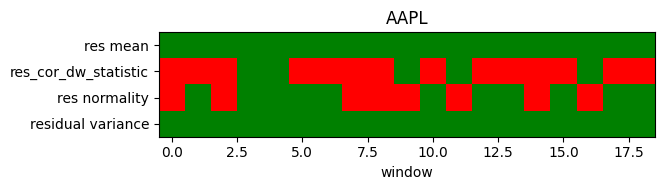

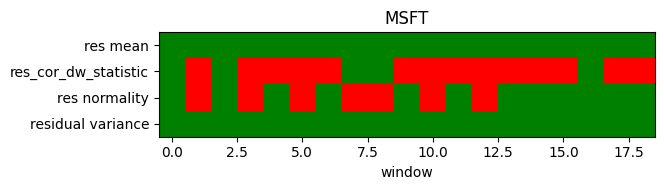

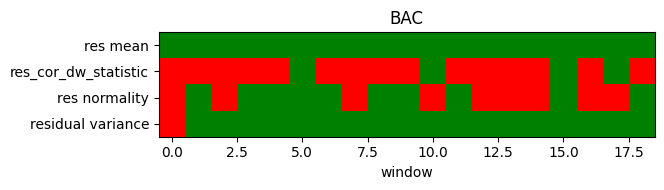

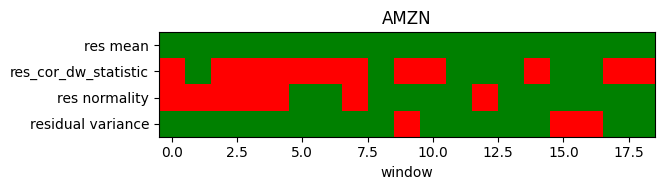

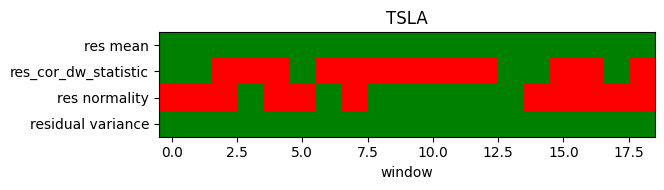

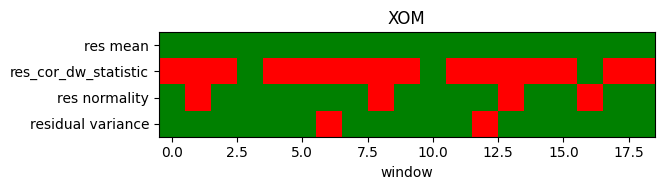

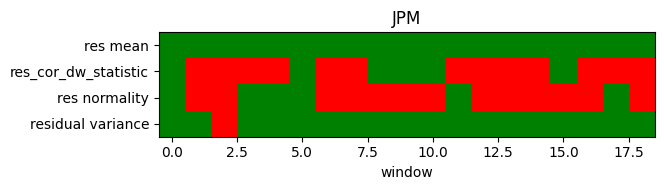

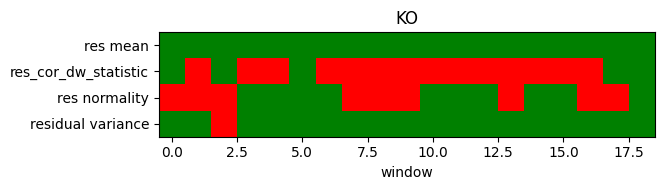

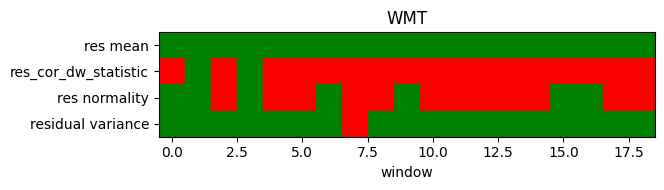

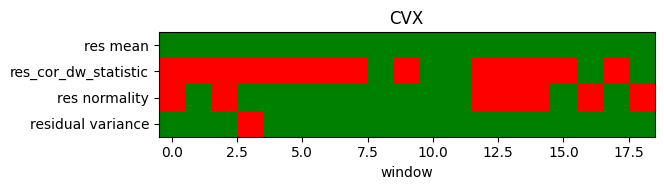

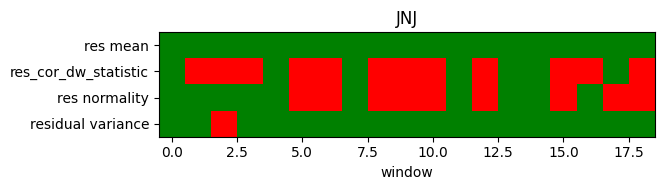

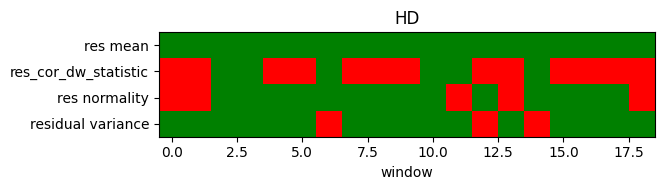

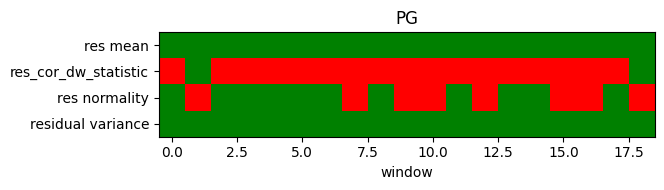

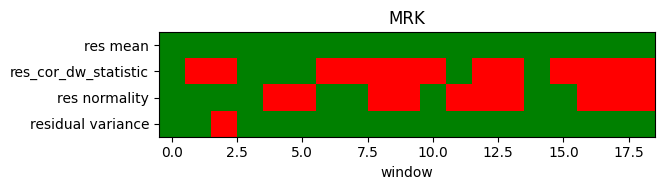

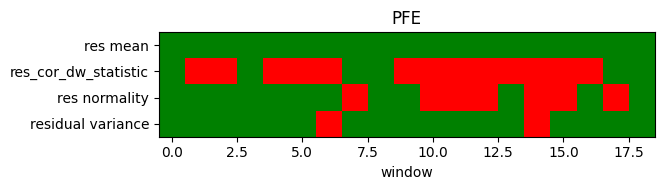

In [31]:
# Plotting assumptions per company
for stock in comp_ass_count.keys():

    cmap = (mpl.colors.ListedColormap(['red', 'green']))

    bounds = [0,0.05]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(1,1)

    df = comp_ass_count[stock].iloc[:,1:].T.astype(int)
    ax.imshow(df, cmap=cmap, norm=norm)
    ax.set_yticklabels(['res mean', 'res_cor_dw_statistic', 'res normality', 'residual variance'])
    ax.set_xlabel("window")
    ax.set_title(f"{stock}")
    ax.set_yticks(range(4))

We can see that residual autocorrelation and normality of residuals and residual autocorrelation tests are often failing.

**Forecasting**

At this stage we want to do the same forecast performed with the VAR model, which involves the period from 2019/12/31 to 2020/1/20. For each company we obtain the actual stock values for this period from Yahoo Finance (this means **12 data points given** there are 12 working days). We use each of the trained models (i.e. one per window) to generate a 12 steps forecast. The actual stock values, the individual model forecast and the averaged forecast value are plotted for each company. Using the prediction error, the average RMSE of the models and the $95\%~CI$ is computed per company.  

Manual prediction function: 

12
[50.38099640816559, 50.37359417636559, 50.38339537894605, 50.40603344569625, 50.40903849764035, 50.38000852959585, 50.34158659335443, 50.36601443368436, 50.43906569208966, 50.4709024913511, 50.36322523219783, 50.22975491280647]
13


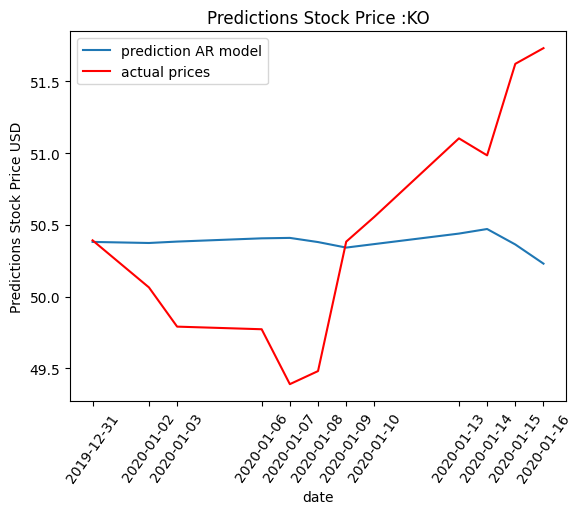

In [32]:
name = 'KO'

model = comp_mod[name][len(comp_mod[name])-1]
initial_values = df_prices[name][-model.ar_lags[-1:][0]:]
test_prices = pd.DataFrame(yf.Ticker(name).history(start = '2019-12-31', end = '2020-1-20')['Close'])['Close']
test_prices


def predictions(model, initial_values, test_prices):
    """ Custom prediction function for AR models, this is done so we can pass the last window of the training data as initial values for the forecast. 
    This is done because the AR model native forecast function only takes the number of steps to forecast as an argument
     and by default assumes the previous window of the training data as the initial values.
    For our case, this is not always wanted.
    For example. If an AR model has 5 lags, and we want to forecast next 5 days, on an out of sample day 1, 
    the AR model will use the last 5 days of the training data window as the initial values, 
    which is not what we want.
    as this window might carry intial values from 2014, when we want to forecast 2020 and we want to use the last 5 days of the previous window in 2019 as the initial values.
    To make passing of these initial values possible, this function was written."""
    model_lags = model.ar_lags[-1:][0]
    model_coefs = model.params
    
    predictions_raw = []
    for i in range(len(test_prices)):
        Xt = copy.deepcopy(predictions_raw)

        u = -1
        while len(Xt) < model_lags:
            Xt.append(initial_values[u]) 
            u -= 1
        pred = model_coefs[0] = sum([model_coefs[i]*Xt[i] for i in range(model_lags)])
        predictions_raw.insert(0,pred)
    
    predictions_clean = []

    # code undo's the percentage change that was applied to the data
    for i in range(len(predictions_raw)-1):
        if i == 0:
            predictions_clean.append(test_prices[i] + predictions_raw[i+1]*test_prices[i])
        else: 
            predictions_clean.append(predictions_clean[len(predictions_clean)-1] + predictions_raw[i+1]*predictions_clean[len(predictions_clean)-1])

    return predictions_clean


preds = predictions(model,initial_values,test_prices)
print(len(preds))
# PLOT PREDICTIONS VS ACTUAL PRICES
# we are slicing data to remove the last day of the test_prices (which is the real prices) because there is no prediction for that day
dates = test_prices.index[:-1]
plt.plot(dates,preds, label = 'prediction AR model')
plt.plot(dates,test_prices[:-1],'r-', label = 'actual prices')
print(preds)
print(len(test_prices))
plt.title(f'Predictions Stock Price :{name}')
plt.ylabel(f'Predictions Stock Price USD')
plt.xlabel("date")
plt.xticks(dates, rotation=55)
plt.legend()
plt.show()


We can see that in the date labels, non-business days and holidays are skipped. Therefore sometimes the delta t is bigger than 1 day.

In [33]:
def preds_and_rmse(company_name, models_list, plot = True):

    test_prices = pd.DataFrame(yf.Ticker(company_name).history(start = '2019-12-31', end = '2020-1-20')['Close'])['Close']
    preds_list = []
    RMSE_list = []

    for model in models_list: 

        initial_values = df_prices[company_name][-model.ar_lags[-1:][0]:]
        predictions_clean = predictions(model,initial_values,test_prices)

        sqr_resid = [(test_prices[i]-predictions_clean[i])**2 for i in range(len(predictions_clean))]
        RMSE = (np.mean(sqr_resid))**0.5


        preds_list.append(predictions_clean)
        RMSE_list.append(RMSE)


    avg_RMSE = np.mean(RMSE_list)
    ci_low = np.percentile(RMSE_list,2.5)
    ci_high = np.percentile(RMSE_list,97.5)

    avg_pred = []
    for i in range(len(preds_list[0])):
        one_time = []
        for p in preds_list:
            one_time.append(p[i])
        avg_pred.append(np.mean(one_time))

    if plot == True:
        return avg_RMSE,ci_low, ci_high, preds_list, avg_pred, test_prices
    else:
        return avg_RMSE,ci_low, ci_high

preds_and_rmse('AAPL',comp_mod['AAPL'],plot = False)

(3.7254837556085296, 2.717473259757238, 4.78295980339223)

Graph with individual model predictions, average prediction and actual stock values per company. 

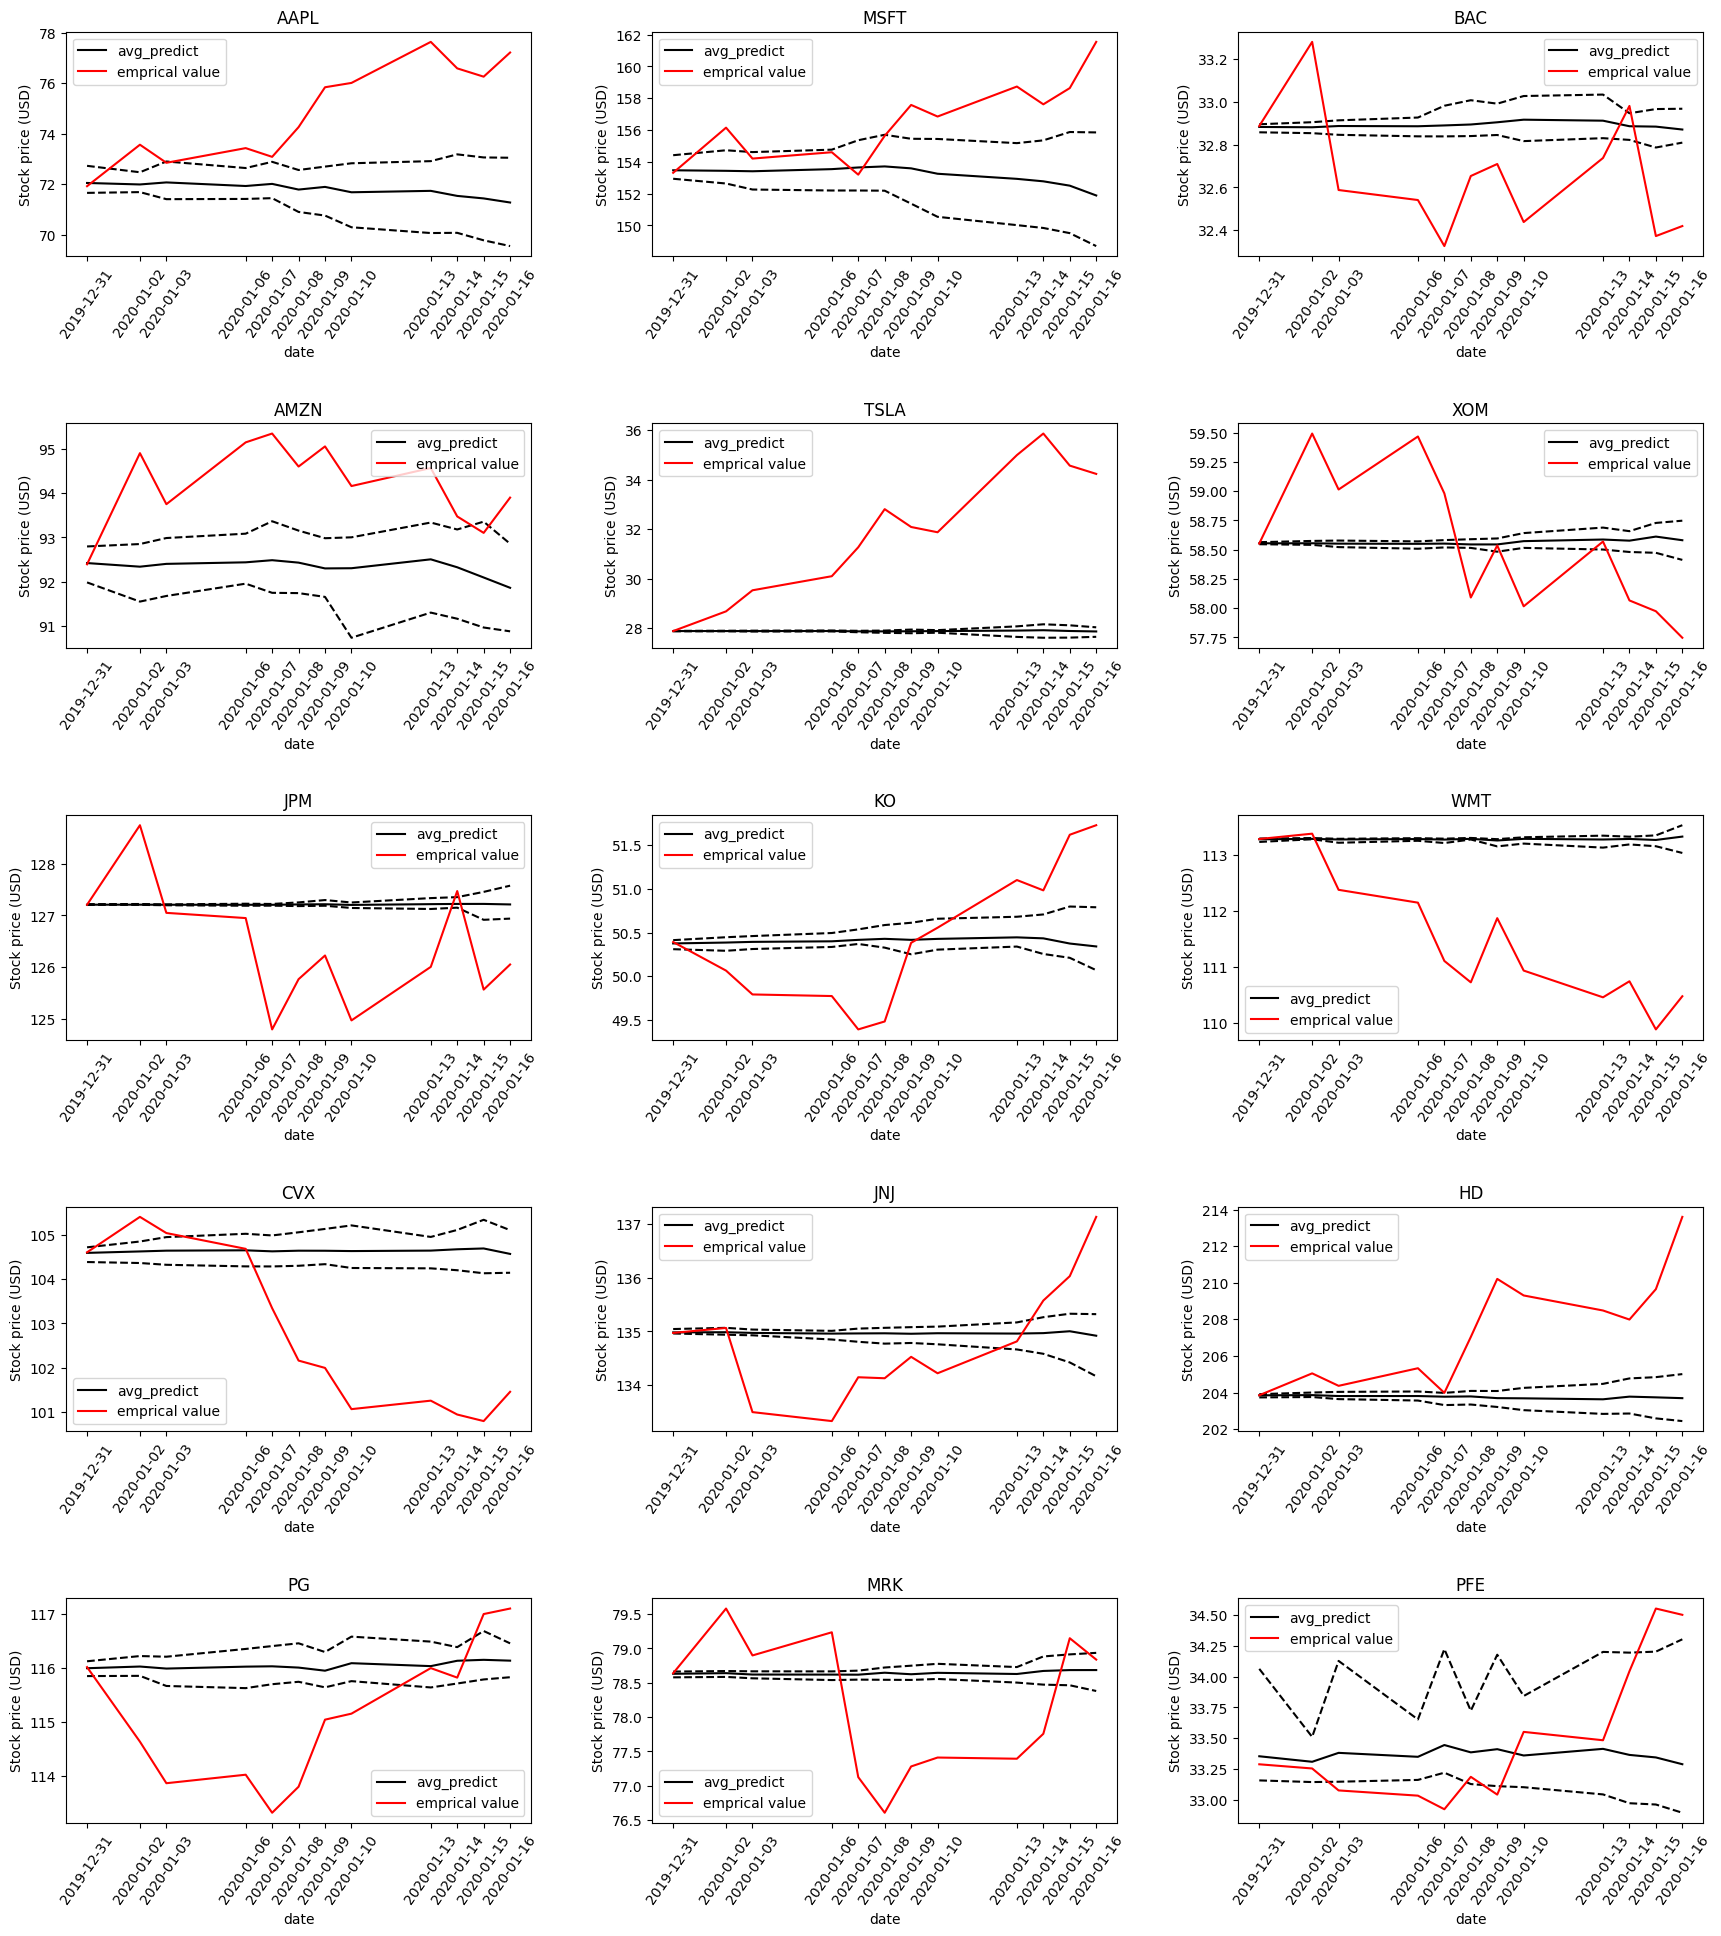

In [34]:
fig = plt.figure(figsize = (18, 20))
for i,name in enumerate(comp_mod,start = 1):

    avg_RMSE, ci_low, ci_high, preds_list,avg_pred,test_prices = preds_and_rmse(name,comp_mod[name])

    plt.subplot(5,3,i)
    
    ci_low = []
    ci_high = []

    for s in range(len(preds_list[1])):
        step = []
        for lis in preds_list:
            step.append(lis[s])
        ci_low.append(np.percentile(step,2.5))
        ci_high.append(np.percentile(step,97.5))
    dates = test_prices.index[:-1]
    len(dates)
    len(avg_pred)
    avg_pred = pd.DataFrame(avg_pred)
    avg_pred.index = dates
    # we are slicing data to remove the last day of the test_prices (which is the real prices) because there is no prediction for that day
    test_prices = pd.DataFrame(test_prices)[:-1]
    ci_low = pd.DataFrame(ci_low)
    ci_low.index = dates
    ci_high = pd.DataFrame(ci_high)
    ci_high.index = dates

 
    
    plt.plot(dates,ci_low,color = 'black',linestyle = 'dashed') 
    plt.plot(dates,ci_high,color = 'black',linestyle = 'dashed') 
    plt.plot(avg_pred.index,avg_pred,color = 'black',label = 'avg_predict')
    plt.plot(test_prices.index,test_prices,color = 'red',label = 'emprical value')
    plt.title(f'{name}')
    plt.xlabel('date')
    plt.xticks(dates, rotation=55)
    plt.ylabel('Stock price (USD)')
    plt.legend()

fig.tight_layout(pad = 3)
plt.show()



Graph with RMSE and its CI per company 

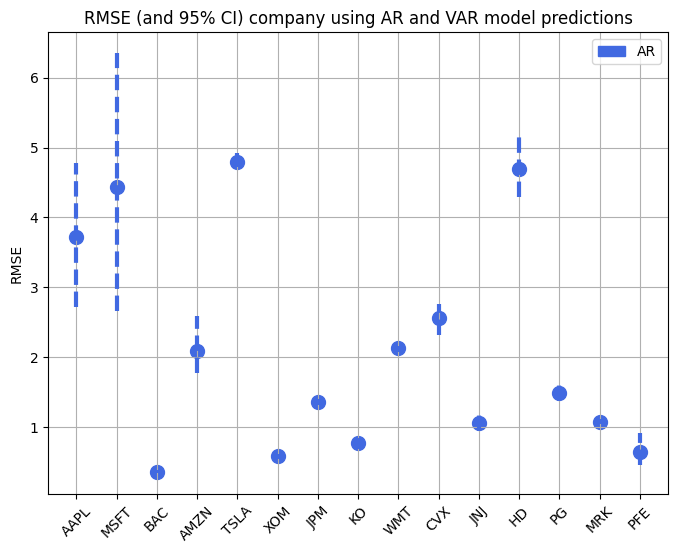

In [35]:
# AR
avg_RMSE = []
low_RMSE = []
high_RMSE = []

for name in comp_mod.keys():
    avg, low, high = preds_and_rmse(name,comp_mod[name],plot = False)
    avg_RMSE.append(avg)
    low_RMSE.append(low)
    high_RMSE.append(high)

# PLOT
fig = plt.figure(figsize = (8,6))
for i,name in enumerate(comp_mod.keys()):
    plt.scatter(i,avg_RMSE[i],color = 'royalblue',s = 100)
    plt.plot(np.repeat(i,2),[low_RMSE[i],high_RMSE[i]],linestyle = 'dashed',linewidth = 3,color = 'royalblue')

plt.xticks(range(len(comp_mod.keys())), labels = comp_mod.keys())

patch1 = mpatches.Patch(color = 'royalblue',label = 'AR')
handles = [patch1]
plt.legend(handles = handles)
plt.xticks(rotation = 45)
plt.ylabel('RMSE')
plt.title('RMSE (and 95% CI) company using AR and VAR model predictions')
plt.grid()
plt.show()



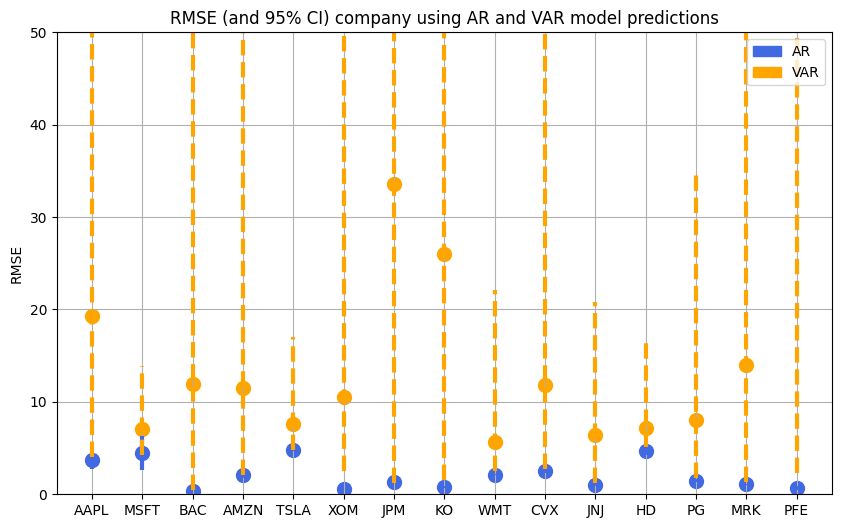

In [36]:
# AR
avg_RMSE = []
low_RMSE = []
high_RMSE = []

for name in comp_mod.keys():
    avg, low, high = preds_and_rmse(name,comp_mod[name],plot = False)
    avg_RMSE.append(avg)
    low_RMSE.append(low)
    high_RMSE.append(high)

# Read RMSE's of the VAR
VAR_rmse_df = pd.read_csv("../data/RMSE_var.csv")
VAR_rmse = VAR_rmse_df.iloc[0].tolist()[1:]
VAR_rmse = [float(value) for value in VAR_rmse]

VAR_CI = VAR_rmse_df.iloc[1].tolist()[1:]
VAR_CI = [ast.literal_eval(CI) for CI in VAR_CI]


# PLOT
fig = plt.figure(figsize = (10,6))
for i,name in enumerate(comp_mod.keys()):
    plt.scatter(i,avg_RMSE[i],color = 'royalblue',s = 100)
    plt.scatter(i,VAR_rmse[i],color = 'orange',s = 100)
    plt.plot(np.repeat(i,2),[low_RMSE[i],high_RMSE[i]],linestyle = 'dashed',linewidth = 3,color = 'royalblue')
    plt.plot(np.repeat(i,2),[VAR_CI[i][0],VAR_CI[i][1]],linestyle = 'dashed',linewidth = 3,color = 'orange')
plt.xticks(range(len(comp_mod.keys())),labels = comp_mod.keys())

patch1 = mpatches.Patch(color = 'royalblue',label = 'AR')
patch2 = mpatches.Patch(color = 'orange',label = 'VAR')
handles = [patch1, patch2]
plt.ylim([0,50])
plt.legend(handles = handles)
plt.ylabel('RMSE')
plt.title('RMSE (and 95% CI) company using AR and VAR model predictions')
plt.grid()

plt.show()


# Hypothesis testing

# H0 B: There is no relationship between sentiment about a stock in news articles and this stock's price movements. 

### Significance test for the difference in RMSE

We can see that the $RMSE$ value for the $AR$ model is systematically smaller than that of the $VAR$ model. Infact, from the plot it looks pretty self evident that the AR RMSE is lower, so one might argue we do not need a statistical test. Nonetheless, some of ranges of found ARs and VAR's overlap, so they might be the same.
To test if this is the case, we want tot know if this difference of VAR and AR RMSE's is statistically significant. Although there are different ways to test this, we follow a similar procedure as for the first hypothesis. First, we count how many of the mean $AR$ RMSE values are lower than the $VAR$ mean RMSE values in the figure above. Then we find how likely this is to occur, under the hypothesis that the mean prediction RMSE is the same for VAR as it is for AR. If this were the case, we would expect both outcomes (RMSE VAR > RMSE AR) and (RMSE VAR smaller or equal RMSE AR) to be equally likely (and thus both occur with a probability of 0.5). If we then define (RMSE VAR > RMSE AR) to be a 'succes' and (RMSE VAR smaller or equal RMSE AR) to be a failure in a binomial test of proportions, this would lead to the follwing null hypothesis of this sub test:


$\textbf{H0}: p = 0.5$  (mean VAR prediction RMSE equal to mean AR prediction RMSE)

With alternative hypotheses:

$\textbf{H1}: p \neq 0.5$  (mean VAR prediction RMSE is not equal to mean AR prediction RMSE)


If we count the number of succeses (RMSE VAR > RMSE AR), we find this is $15$ out of $15$. 
The $p-value$ of this observation would be the probability of observing this or a more extreme outcome if H0 is true.
This probability follows a binomial distribution with $p = 0.5$, k = 15, n = 15. 
Again we assume the distribution of probabilities to be independent. 
We test as significance level alpha = 0.05 , this leads to the following p-value:

$$P(x \geq 15) = \binom{15}{15}0.5^{15}(1-0.5)^{0} = 0.5^{15} =  0.305 * 10^{-5} = p-value $$


Thus, given this sample, significance and assumptions, we reject $\textbf{H0}: p = 0.5$ (mean prediction RMSE is the same for VAR as it is for AR) if favor of $\textbf{H1}: p \neq 0.5$  (mean VAR prediction RMSE is not equal to mean AR prediction RMSE).
From the plot we can then see

In [37]:
p_value = 1 - binom.cdf(15, 15, 0.5)
print('Found p-value: ', round(p_value,4))
if round(p_value,4) < 0.05:
    print('p_value < 0.05 (alpha), thus:')
    print('H0: p = 0.5 (mean prediction RMSE is the same for VAR as it is for AR) is rejected in favor of H1: p != 0.5 (mean prediction RMSE for VAR is different than mean prediction RMSE for AR)')
elif round(p_value,4) > 0.05:
    print('p_value > 0.05 (alpha), thus:')
    print('H0 (proportion of significant sentiments coefficients in price timeseries = 0.05) is NOT rejected')

Found p-value:  0.0
p_value < 0.05 (alpha), thus:
H0: p = 0.5 (mean prediction RMSE is the same for VAR as it is for AR) is rejected in favor of H1: p != 0.5 (mean prediction RMSE for VAR is different than mean prediction RMSE for AR)


$$P(x \geq 15) = \binom{15}{15}0.5^{15}(1-0.05)^{0} = 0.5^{15}$$

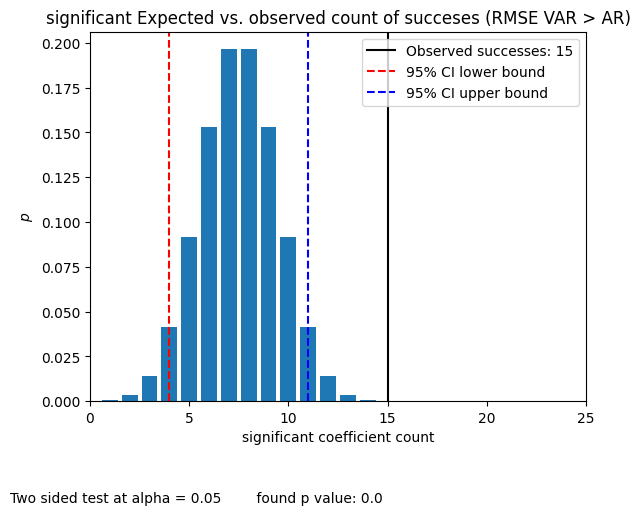

<Figure size 1500x1500 with 0 Axes>

In [38]:
n = 15
k = 15
p = 0.5
binom_data = [binom.pmf(r, n, p) for r in range(n+1) ]
plt.bar( range(n+1), binom_data)
plt.axvline(k, color = 'black',label = f'Observed successes: {str(k)}')
plt.title("significant Expected vs. observed count of succeses (RMSE VAR > AR)")
CI_95_two_sided = [binom.ppf(0.025, 15, 0.5), binom.ppf(0.975, 15, 0.5)]
plt.axvline(CI_95_two_sided[0], color = 'r',linestyle = 'dashed',label = '95% CI lower bound')
plt.axvline(CI_95_two_sided[1], color = 'b',linestyle = 'dashed',label = '95% CI upper bound')
plt.legend()
plt.xlabel(r'significant coefficient count')
plt.ylabel(r'$p$')
plt.xlim([0,25])
plt.figtext(x=0, y =-0.1, s= f'Two sided test at alpha = 0.05        found p value: {str(round(p_value,4))}')
plt.figure(figsize=(15,15))
plt.show()

Based on this results we can reject the hypothesis that both $RMSE$ values for the $AR$ and the $VAR$ model stem from the same distribution. All and all, this points at the differences we observed in the $RMSE$ being significant and thus the $VAR$ being significantly worse than the $AR$

Concluding, in the plot we see the mean RSME of the VAR is higher than the mean RMSE of the AR for all 15 stocks. Eventhough the ranges of the RMSE's sometimes overlap, we have found support that the mean RMSE's of the VAR and AR are infact different. Thus we can form a conclusion about our main hypothesis:
H0 B: Future stock price predictions can not be improved by including news article sentiment about this stock as a predictor -> not rejected, given this sample, assumptions and significance.

### Appendix 

Stuff that may still be relevant but are not part of the main/final workflow

Fitting the model to the entire time series per company 

In [39]:
lags = [13,16,6,9,4,5,4,8,5,10,7,5,8,6,16]
AR_models = []
res_av = []
norm_test = []
assumptions = pd.DataFrame({'stock': list(df_prices),'res_avg':np.repeat(0,len(list(df_prices))),'res_autocor':np.repeat(0,len(list(df_prices))),
'normality (p-value)':np.repeat(0,len(list(df_prices)))})
# stationarity is ofcourse also an assumption, but we already checked that in the previous notebooks
for i, comp in enumerate(df_prices.columns):
    p = lags[i]
    data = df_prices[comp]

    ar_model = AutoReg(data, lags=p).fit()

    AR_models.append(ar_model)

    # 2. RES AVG = 0
    res_av.append(np.mean(ar_model.resid))

    # 3. AUTOCORRELATED RESIDUALS MISSING!!
    # reference: reference: https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoRegResults.test_serial_correlation.html
    ar_model.test_serial_correlation(lags=p)


    # 4. NORMALITY (ONLY OUTPUT THE P-VALUE)
    # reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html
    norm_test.append(jarque_bera(AR_models[0].resid)[1])

assumptions['res_avg'] = res_av
assumptions['normality (p-value)'] = norm_test

df_prices.head()

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE
2014-01-06,0.005453,-0.021133,0.015235,-0.007088,-0.017117,0.001507,0.005796,-0.004696,-0.005595,-0.002654,0.005226,-0.009647,0.002362,0.000201,0.000983
2014-01-07,-0.007151,0.007750,-0.009604,0.011178,0.016054,0.014149,-0.011525,0.002980,0.003069,0.008466,0.021228,0.004932,0.009673,0.007439,0.006220
2014-01-08,0.006333,-0.017852,0.004848,0.009773,0.012855,-0.003265,0.009431,-0.011142,-0.007903,-0.014232,-0.001379,0.005276,-0.014493,-0.006386,0.006831
2014-01-09,-0.012770,-0.006432,0.015079,-0.002264,-0.024788,-0.009728,-0.001869,-0.005258,0.003341,0.000000,0.006053,-0.004394,0.002244,-0.005423,-0.000646
2014-01-10,-0.006672,0.014354,-0.003565,-0.008354,-0.012269,0.007618,-0.004595,0.010068,-0.000640,-0.018493,0.000106,0.005394,-0.001492,0.007270,-0.007759


In [40]:
assumptions

,stock,res_avg,res_autocor,normality (p-value)
0,AAPL,2.939263e-18,0,2.952237e-241
1,MSFT,-3.065789e-16,0,2.952237e-241
2,BAC,2.407088e-19,0,2.952237e-241
3,AMZN,5.473192e-18,0,2.952237e-241
4,TSLA,-7.396556e-20,0,2.952237e-241
5,XOM,-6.759408e-17,0,2.952237e-241
6,JPM,1.849139e-19,0,2.952237e-241
7,KO,-2.410304e-19,0,2.952237e-241
8,WMT,0.000000e+00,0,2.952237e-241
9,CVX,9.746941e-20,0,2.952237e-241
